In [81]:
import numpy as np
from multiprocessing import Pool
from functools import partial
import plotly.graph_objects as go
import gzip
import pickle as pkl

import games
import synthetic_data
import random_algo


import cpb_side
import cpb_side_gaussian
import linucb


import PGIDSratio
import synthetic_data
import numpy as np
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


class FakeIds():

    def __init__(self, M, imbalance):

        self.imbalance = imbalance
        self.M = M
        self.dim = len(imbalance)
        self.labels = [i for i in range(self.dim)]
        
        
    def get_contexts(self, horizon, game):

        contexts = np.empty( ( horizon, 10) )
        outcomes = np.zeros( horizon, dtype = int)

        for i in range(horizon):

            label = np.random.choice( self.labels , p = self.imbalance)

            contexts[i] = np.zeros(10)
            pred_label = np.random.choice(  self.labels , p = self.M[label] )
            contexts[i][pred_label] = 1
            
            if pred_label != label:
                outcomes[i] = 1
            else:
                outcomes[i] = 0
                
        return outcomes, contexts

    def get_context(self, ):
        label = np.random.choice( self.labels , p = self.imbalance)

        context = np.zeros(self.dim)
        pred_label = np.random.choice(  self.labels , p = self.M[label] )
        context[pred_label] = 1
            
        if pred_label != label:
            outcome = 1
        else:
            outcome = 0
                
        return outcome, context

class Evaluation:

    def __init__(self, ground_truth, epsilon, n_labels, deltas , optim_action):
        self.ground_truth = ground_truth
        self.epsilon = epsilon
        self.n_labels = n_labels
        self.deltas = deltas
        self.optim_action = optim_action

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, context_generator,):
    
        alg.reset()

        estimates_history = {}

        t = 0
        queries_counter = 0
        latest_estimate = np.ones(len(self.ground_truth)) * 1000
        # print('ground truth', self.ground_truth )
        status = True

        cumRegret =  []
        # action_counter = np.zeros( (game.n_actions, self.horizon) )

        while status == True:
            
            outcome, context = context_generator.get_context() 
            lb =  np.argmax(context)
            i_star = self.optim_action[lb]
            context = context.reshape((-1,1))

            if t % 1000 == 0 and t>0 :
                print(t, 'latest estimate', latest_estimate)

            if t>2 and alg.name == 'randcbpside':
                estimates = []
                for i in range( self.n_labels ):
                    sim = np.zeros( self.n_labels )
                    sim[i] = 1
                    estimate = alg.contexts[1]['weights'] @ sim
                    estimates.append( estimate[0] )
                latest_estimate = estimates

            elif t>2 and alg.name == 'random':
                latest_estimate = alg.weights[:,0]

            if ( abs( self.ground_truth - latest_estimate  ) <= self.epsilon ).all() :
                status = False            

            # policy chooses one action
            #print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t, context)

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )
            
            #distrib = np.array( [ ground_truth[lb], 1 - ground_truth[lb] ] )
            # regret =  game.LossMatrix[action, ] - game.LossMatrix[i_star, ] #) @ distrib

            regret = self.deltas[lb][action] 
            # print(regret)
            cumRegret.append( regret )
            t = t+1

            # regret = self.deltas[i_star] #np.array( [ self.deltas[i_star] ).T @ action_counter
            # regret = np.array( [ game.delta(i) for i in range(game.n_actions) ] ).T @ action_counter
            
        return  cumRegret


In [82]:
class Random():

    def __init__(self, game, n_labels):

        self.name = 'random'

        self.n_labels = n_labels
        self.game = game

        self.weights = np.ones( (self.n_labels,2) )
        self.feedbacks = np.zeros( (self.n_labels,2) )
        self.N = np.zeros( self.n_labels )

    def get_action(self, t, context = None ):
        
        pbt = np.ones( self.game.n_actions ) / self.game.n_actions
        action = np.random.choice(self.game.n_actions, 1,  p = pbt )[0]
        return action

    def update(self, action, feedback, outcome, t, context):
        if action == 1:
            idx = np.argmax(context)
            self.feedbacks[idx][feedback] += 1
            self.N[idx] += 1
            estimates = [ self.feedbacks[i] / self.N[i] if self.N[i] !=0 else np.zeros( (1,2) ) for i in range(len(self.N) ) ] 
            self.weights = np.vstack(estimates)

    def reset(self,):
        self.weights = np.ones( (self.n_labels,2) )
        self.feedbacks = np.zeros( (self.n_labels,2) )
        self.N = np.zeros( self.n_labels )


def confusion_matrix(M, errors, n_labels):

    for i in range(n_labels):

        M[i][i] -= errors[i]
        n_splits = np.random.randint(1, n_labels-1) 

        coefs = np.random.uniform(0, 1, n_splits)
        coefs = coefs / sum(coefs)

        for idx in range(n_splits):

            status = True
            while status == True:
                location = np.random.randint(0, n_labels)
                if location != i:
                    status = False

            M[i][location] += coefs[idx] *  errors[i]

    return M

def truncate(value):
    if value<-1 or value>1:
        status = False
        while status == False:
            value = abs( np.random.normal(0, 0.1 ) )
            if value <1:
                status = True
    return value

def get_ground_truth(M, imbalance):
    # correct probabilities
    probas_correct = np.diag(M) * imbalance

    # correct probabilities
    probas_incorrect = M.copy()
    np.fill_diagonal( probas_incorrect, 0 ) 
    probas_incorrect = np.sum( probas_incorrect.T * imbalance, 1)

    # final probabilites
    final_probas = probas_incorrect / (  probas_correct + probas_incorrect )
    return final_probas


# self.LossMatrix[action,...] - self.LossMatrix[self.i_star,...] ).T @ list( self.outcome_dist.values()

def optimal_action(game, ground_truth):
        deltas = {}
        optim_action = {}

        for lb in range( len(ground_truth) ):

            distribution = [ 1- ground_truth[lb],  ground_truth[lb] ]
            delts = []
            for i in range(len(game.LossMatrix)):
                delts.append( game.LossMatrix[i,...].T @ distribution  )
            deltas[lb] = delts
            optim_action[lb] = np.argmin(deltas[lb])

        return deltas , optim_action


game = games.apple_tasting(False)

n_trials = 100


regrets1 = []
regrets2 = []

for trial in range(n_trials):

    print(trial)

    np.random.seed(trial)

    n_labels = 10 # np.random.randint(3, 30)
    imbalance = np.array( [ np.random.uniform(50, 75) if np.random.uniform(0,1)<0.1 else np.random.uniform(0,25) for _ in range(n_labels) ] )
    imbalance = np.ones(n_labels) / n_labels #imbalance / sum(imbalance)

    M = np.identity(n_labels)
    errors = np.array( [ truncate( abs( np.random.normal(0.5, 0.5 ) ) ) if np.random.uniform(0,1)<0.1 else truncate( abs( np.random.normal(0, 0.2 ) ) ) for _ in range(n_labels) ] )
    M = confusion_matrix(M, errors, n_labels)
    
    ground_truth = get_ground_truth(M, imbalance)
    print('ground truth', ground_truth)

    epsilon = 0.025

    deltas , optim_action = optimal_action(game, ground_truth)
    print(optim_action)

    task = Evaluation(ground_truth , epsilon, n_labels, deltas , optim_action ) 
    contexts_generator = FakeIds(M, imbalance )

    alg = cpb_side_gaussian.RandCPB_side(game, n_labels, None, 1.01, 0.001, 1/8, 10, False, 10e-7)  
    regret1  = task.eval_policy_once(alg, game, contexts_generator)
    regrets1.append(regret1)

    alg = Random(  game, n_labels )
    regret2 = task.eval_policy_once(alg, game, contexts_generator)
    regrets2.append(regret2)


#     for idx, alg in enumerate([ Random(  game, n_labels ),  cpb_side_gaussian.RandCPB_side(game, n_labels, None, 1.01, 0.001, 1/8, 10, False, 10e-7)  ]):

#         t, queries_counter = task.eval_policy_once(alg, game, contexts_generator)


#     print('steps', results_steps[trial], 'queries', results_queries[trial] )
#     print()

0
ground truth [0.09922041 0.04537511 0.19144442 0.14259311 0.17274138 0.06884606
 0.11698032 0.11978266 0.17298433 0.08734292]
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
1000 latest estimate [0.1063829787234043, 0.0, 0.2190476190476191, 0.16129032258064524, 0.1547619047619048, 0.0681818181818182, 0.11000000000000004, 0.16814159292035405, 0.24107142857142866, 0.0991735537190083]
2000 latest estimate [0.12796208530805683, 0.014084507042253528, 0.19111111111111115, 0.1629955947136564, 0.1470588235294118, 0.11695906432748539, 0.11792452830188677, 0.16438356164383564, 0.1863636363636364, 0.09004739336492888]
3000 latest estimate [0.11349693251533736, 0.01754385964912281, 0.2006079027355622, 0.1762917933130698, 0.17358490566037735, 0.08745247148288972, 0.10248447204968937, 0.13897280966767364, 0.2103559870550161, 0.09477124183006533]
4000 latest estimate [0.11007025761124117, 0.03559870550161811, 0.200902934537246, 0.17633410672853822, 0.17759562841530044, 0.08587257617728

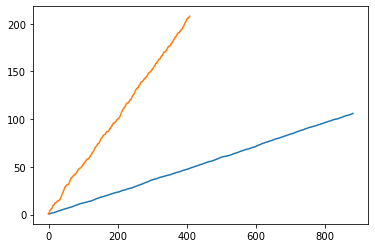

In [79]:
plt.plot( np.cumsum(regret1 ), label = 'RandCBPside' )
plt.plot( np.cumsum(regret2 ), label = 'Random' )

In [91]:
max1 = [ np.cumsum(regrets1[i])[-1] for i in range(len(regrets1)) ]
max2 = [ np.cumsum(regrets2[i])[-1] for i in range(len(regrets2)) ]

time1 = [ len(regrets1[i]) for i in range(len(regrets1)) ]
time2 = [ len(regrets2[i]) for i in range(len(regrets2)) ]

print('average cost', np.mean(max1), 'average time', np.mean(time1), np.std(time1) )
print('average cost', np.mean(max2), 'average time',  np.mean(time2), np.std(time2) )

average cost 708.4855935557243 average time 3832.8 1803.6435235378415
average cost 8017.889874390416 average time 16036.1 15802.33707050954


In [20]:
import pandas as pd





df = np.vstack( [ np.array([0,1,2,3,4,5,6,7,8,9]),  np.round( final_probas , 2) ] ).T
df = pd.DataFrame(df)
df.columns = ['index', 'ground_truth'] 

for k in estimates_history.keys():
    df[str(k)] = estimates_history[k]

steps = round( (224 - 96) / len(estimates_history.keys() ) )
greys = np.arange(224, 96, -steps)

fig = go.Figure( )

for i , k in enumerate( estimates_history.keys() ):
    col = greys[i]
    fig.add_trace(go.Scatter(x=df['index'], y=df[str(k)], line=dict(color='rgb({},{},{})'.format(col,col,col) ) ,mode='lines+markers',  name='{} rounds'.format(k),   showlegend=True ))

fig.add_trace(go.Scatter(x=df['index'], y=df['ground_truth'], text = df['ground_truth'],  line=dict(color='rgb(255,0,0)' ), textfont=dict( family="sans serif", size=18) ,mode='lines+markers+text',  name='Deployment Error (ground truth)',   showlegend=True ))

fig.update_traces(textposition="top center")

fig.update_layout(yaxis_range=[-0.1,1])

fig.show(legend=True)
# fig.write_image("./estimates_imbalanced.png")

In [ ]:
import gzip
import pickle as pkl

n_cores = 8
n_folds = 25
horizon = 2500

game = games.apple_tasting(False)

algos = [ random_algo.Random(  game, horizon, ),    
          cpb_side.CPB_side(  game, horizon, 1.01, 0.05), 
          cpb_side_gaussian.RandCPB_side(game, horizon, 1.01, 0.05, 1/8, 10, False, 10e-7),
          linucb.LinUCB(game, horizon, 1.01)   ] #cpb_side_gaussian.CPB_side_gauss(game, horizon, 1/16, 10)

colors = [  [0,0,0], [250,0,0], [0,250,0] , [0,0,250]  ] #, [250,0,0]
labels = [  'random', 'CBP-side 0.05',  'RandCPB-side 0.001', 'linUCB' ] #  'Rand CPB-side'

fig = go.Figure( )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    np.save('./results/apple_tasting/easy_context_{}_{}_{}'.format(horizon,n_folds, label), result)
    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )

fig.show(legend=True)

# fig.write_image("./easy_AT_context.pdf")

#fig.update_xaxes(type="log")
# fig.write_image("./easy_AT_context_log.pdf")

fig.show()

In [104]:
import gzip
import pickle as pkl

# direct = './use_case_results/{}'.format(name)
with gzip.open( './use_case_results/random_5.pkl.gz','rb') as f:
    result = pkl.load(f)
print(result)

[[0.046856636082122524, 0.046856636082122524, 0.0, 0.0, 0.9531433639178775, 0.17977716302128313, 0.046856636082122524, 0.046856636082122524, 0.8202228369787169, 0.9531433639178775, 1.0, 0.3941613047908414, 0.046856636082122524, 0.9531433639178775, 0.3941613047908414, 0.9531433639178775, 0.0, 1.0, 0.3941613047908414, 0.6058386952091586, 0.3941613047908414, 0.8202228369787169, 0.3941613047908414, 0.8175061714223684, 0.046856636082122524, 0.8202228369787169, 0.8202228369787169, 0.17977716302128313, 0.046856636082122524, 0.17977716302128313, 1.0, 0.9531433639178775, 0.3941613047908414, 0.8202228369787169, 0.9531433639178775, 0.046856636082122524, 0.9531433639178775, 0.9531433639178775, 0.046856636082122524, 0.046856636082122524, 0.046856636082122524, 0.046856636082122524, 0.17977716302128313, 1.0, 0.17977716302128313, 0.046856636082122524, 0.046856636082122524, 0.0, 0.9531433639178775, 0.046856636082122524, 0.9531433639178775, 0.046856636082122524, 0.9531433639178775, 0.8202228369787169, 0